## The Challenge
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

## Import dataset

In [2]:
df=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

## Data Overview

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


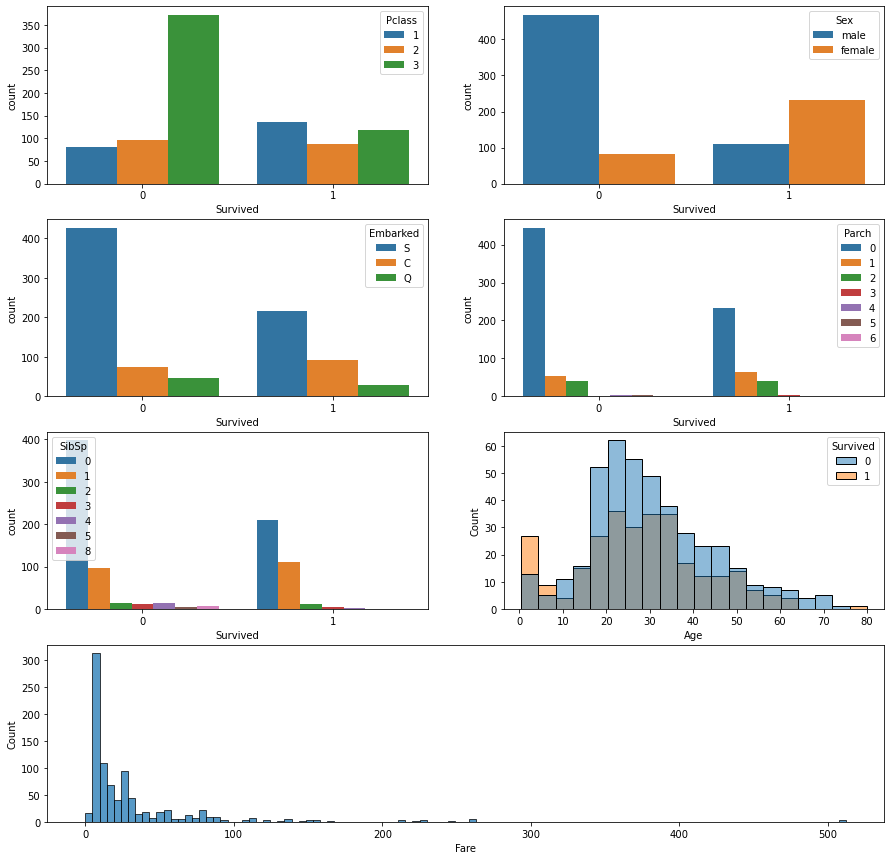

In [6]:
fig, axs = plt.subplots(4,2, figsize=(15,15))

sns.countplot(ax=axs[0,0], x="Survived",hue="Pclass",data=df)
sns.countplot(ax=axs[0,1], x="Survived",hue="Sex",data=df)
sns.countplot(ax=axs[1,0], x="Survived",hue="Embarked",data=df)
sns.countplot(ax=axs[1,1], x="Survived",hue="Parch",data=df)
sns.countplot(ax=axs[2,0], x="Survived",hue="SibSp",data=df)
sns.histplot(ax=axs[2,1], x="Age", hue="Survived", data=df)

ax1=plt.subplot(414)
sns.histplot(ax=ax1, x="Fare", data=df)

plt.show()

## Replacing missing data and encoding

In [7]:
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna('S', inplace=True)

df_test['Age'].fillna(df_test['Age'].median(), inplace=True)
df_test['Embarked'].fillna('S', inplace=True)
df_test['Fare'].fillna(df_test['Fare'].median(), inplace=True)

X_train=df.drop(columns=['Survived','Name','Cabin','Ticket'])
df_test.drop(columns=['Name','Cabin','Ticket'], inplace=True)
Y_train=df['Survived']
X_train

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,male,22.0,1,0,7.2500,S
1,2,1,female,38.0,1,0,71.2833,C
2,3,3,female,26.0,0,0,7.9250,S
3,4,1,female,35.0,1,0,53.1000,S
4,5,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,887,2,male,27.0,0,0,13.0000,S
887,888,1,female,19.0,0,0,30.0000,S
888,889,3,female,28.0,1,2,23.4500,S
889,890,1,male,26.0,0,0,30.0000,C


In [8]:
le=preprocessing.LabelEncoder()

X_train[['Sex']]=le.fit_transform(X_train[['Sex']])
df_test[['Sex']]=le.transform(df_test[['Sex']])

X_train['Embarked'][X_train['Embarked'].notnull()]=le.fit_transform(X_train[['Embarked']][X_train['Embarked'].notnull()])
df_test['Embarked'][df_test['Embarked'].notnull()]=le.transform(df_test[['Embarked']][df_test['Embarked'].notnull()])

X_train

C:\Users\Adam\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
<ipython-input-8-dd244cd8b51b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Embarked'][X_train['Embarked'].notnull()]=le.fit_transform(X_train[['Embarked']][X_train['Embarked'].notnull()])
<ipython-input-8-dd244cd8b51b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['Embarked'][df_test['Embarked'].notnull()]=le.transform(df_test[['Embarked']][

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,3,1,22.0,1,0,7.2500,2
1,2,1,0,38.0,1,0,71.2833,0
2,3,3,0,26.0,0,0,7.9250,2
3,4,1,0,35.0,1,0,53.1000,2
4,5,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...,...
886,887,2,1,27.0,0,0,13.0000,2
887,888,1,0,19.0,0,0,30.0000,2
888,889,3,0,28.0,1,2,23.4500,2
889,890,1,1,26.0,0,0,30.0000,0


# Training algorithm

## Decision Tree

In [9]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3)

clf=DecisionTreeClassifier()
clf.fit(train_x,train_y)
pred_y=clf.predict(test_x)

print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("F1:",metrics.f1_score(test_y, pred_y))

Accuracy: 0.7313432835820896
F1: 0.6571428571428571


## Random Forest

In [10]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3)

clf=RandomForestClassifier(n_estimators=30)
clf.fit(train_x,train_y)
pred_y=clf.predict(test_x)

print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("F1:",metrics.f1_score(test_y, pred_y))

Accuracy: 0.8097014925373134
F1: 0.7487684729064038


## naive bayes gaussian

In [11]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3)

clf=GaussianNB()
clf.fit(train_x,train_y)
pred_y=clf.predict(test_x)

print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("F1:",metrics.f1_score(test_y, pred_y))

Accuracy: 0.7761194029850746
F1: 0.7272727272727274


## LogisticRegression with lasso

In [12]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3)

clf=LogisticRegression(penalty="l1",solver='liblinear', random_state=1)
clf.fit(train_x,train_y)
pred_y=clf.predict(test_x)

print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("F1:",metrics.f1_score(test_y, pred_y))

Accuracy: 0.7910447761194029
F1: 0.7200000000000001


## LogisticRegression with ridge

In [13]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3)

clf=LogisticRegression(penalty="l2",solver='liblinear', random_state=1)
clf.fit(train_x,train_y)
pred_y=clf.predict(test_x)

print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("F1:",metrics.f1_score(test_y, pred_y))

Accuracy: 0.7723880597014925
F1: 0.6965174129353234


## Gradient Boosting

In [14]:
train_x, test_x, train_y, test_y = train_test_split(X_train, Y_train, test_size=0.3)

clf=GradientBoostingClassifier()
clf.fit(train_x,train_y)
pred_y=clf.predict(test_x)

print("Accuracy:",metrics.accuracy_score(test_y, pred_y))
print("F1:",metrics.f1_score(test_y, pred_y))

Accuracy: 0.832089552238806
F1: 0.7715736040609136
